In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.mixture import GaussianMixture
from sklearn import mixture
import datetime as dt
import itertools
from mpl_toolkits import mplot3d
%matplotlib inline

In [4]:
# Data snapshot from 3/11/2022
# https://donnees.montreal.ca/ville-de-montreal/actes-criminels
data = pd.read_csv("data/montreal_crime_data.csv", encoding='latin1')

In [5]:
data.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,-76.237290,0.000000
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,-76.237290,0.000000


## Preprocessing & exploring

In [6]:
data.columns

Index(['CATEGORIE', 'DATE', 'QUART', 'PDQ', 'X', 'Y', 'LONGITUDE', 'LATITUDE'], dtype='object')

#### Meta information of data

In [7]:
print(f"Shape of data is: {data.shape}")

Shape of data is: (214322, 8)


In [8]:
pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')

,Datatype
Columns,
CATEGORIE,object
DATE,object
QUART,object
PDQ,float64
X,float64
Y,float64
LONGITUDE,float64
LATITUDE,float64


## Data cleaning

#### Converting date feature to datatime format

In [9]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [10]:
data['DATE'].head()

0   2018-09-13
1   2018-04-30
2   2018-09-01
3   2017-07-21
4   2017-07-29
Name: DATE, dtype: datetime64[ns]

In [11]:
datatypes = pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')
datatypes

,Datatype
Columns,
CATEGORIE,object
DATE,datetime64[ns]
QUART,object
PDQ,float64
X,float64
Y,float64
LONGITUDE,float64
LATITUDE,float64


#### Checking for NaN values

In [12]:
pd.DataFrame(data.isnull().sum(), columns=['Nb of missing values']).rename_axis('Feature')

,Nb of missing values
Feature,
CATEGORIE,0
DATE,0
QUART,0
PDQ,5
X,0
Y,0
LONGITUDE,0
LATITUDE,0


## Modélization

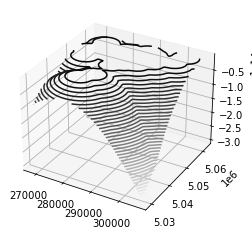

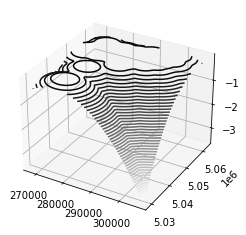

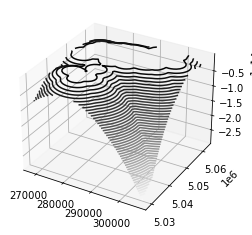

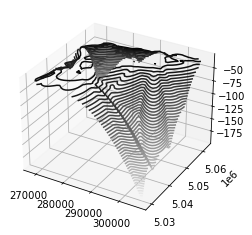

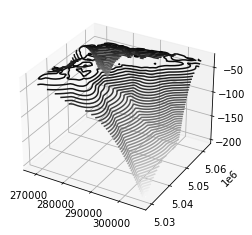

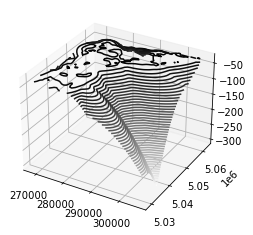

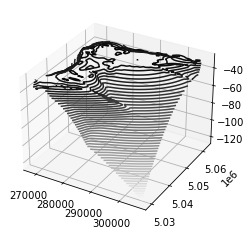

In [ ]:
for category in np.unique(data.CATEGORIE):
    for quart in np.unique(data.QUART):
        cat = (data.CATEGORIE == category)
        qrt = (data.QUART == quart)
        pgx = (data.X > 1000)
        plx = (data.X < 1e6)
        pgy = (data.Y > 1000)
        split_data = data[cat*qrt*pgx*plx*pgy]
        #print(split_data)
        #print(len(split_data.index))
        
        mindate = data.DATE.min()
        def timetofloat(d):
            deltas = (d - mindate)  / np.timedelta64(1,'D')
            return deltas
        coords = np.vstack((split_data.X, split_data.Y, timetofloat(split_data.DATE))).T
        #coords.sort()
        coords = np.unique([tuple(row) for row in coords], axis=0)
        #print(coords)
        #print(len(coords))
        
        ncomponents = min(100,len(coords))
        classifier = GaussianMixture(n_components=ncomponents, covariance_type="full")
        
        #plt.scatter(coords[:,0],y=coords[:,1])
        #plt.show
        #plt.clf()
        #plt.cla()
        #plt.close()
        
        classifier.fit(coords)
        
        minx = data[pgx*plx*pgy].X.min()
        maxx = data[pgx*plx*pgy].X.max()
        miny = data[pgx*plx*pgy].Y.min()
        maxy = data[pgx*plx*pgy].Y.max()
        maxdatef = timetofloat(data.DATE.max())
        testdata = np.array([[ 294904, 5047548, maxdatef],
                            [ 294904, 5047548, maxdatef],
                            [ 290274, 5042150, maxdatef],
                            [ 299344, 5040364, maxdatef],
                            [ 294968, 5047651, maxdatef],
                            [ 291553, 5035569, maxdatef]])
        
        #print(classifier.means_)

        colors = []
        for i in range(ncomponents):
            colors.append(tuple(np.random.uniform(0.3, 1, size=3)))
    
        #dcolors = [colors[i] for i in classifier.predict(testdata)]
        #dcolors = [colors[i] for i in classifier.predict(coords)]


        #ax = plt.gca()
        #plt.clf()
        #plt.cla()
        #plt.close()
        #plt.scatter(testdata[:,0], testdata[:,1], c=dcolors, alpha=0.8)
        #plt.scatter(coords[:,0], coords[:,1], c=dcolors, alpha=0.8)
        #plt.show()
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        resolution = 50
        plotx = np.linspace(minx, maxx, num=resolution)
        ploty = np.linspace(miny, maxy, num=resolution)
        
        
        X, Y = np.meshgrid(plotx, ploty)    #grid de points pour le plot 3D, resolution^2 points
        T = maxdatef*np.ones(shape=X.shape) #T c'est le moment auquel on fait la prediction
        #print(X)
        #print(Y)
        #print(T)
        
        Z = []
        for x in plotx:
            zprime = []
            for y in ploty:
                val = classifier.score_samples(np.array([[x,y,maxdatef]]))[0]
                zprime.append(val)
            Z.append(zprime)
        
        Z = np.array(Z)
        #Z = classifier.predict_proba(np.vstack([X,Y,T]).T) #avoir la prediction pour chaque point
        
        ax.contour3D(X, Y, Z, 50, cmap='binary')
        
        plt.show()

## Visualization